# Exploratory analysis of mempool telementry experiment

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

In [2]:
bauTime <- as.POSIXct("2025-11-22 02:00:00", tz = "UTC")

In [3]:
bauSlot <- 172210527

## Mempool vs blocks

In [4]:
mempoolBlocks <- fread("mempool-vs-blocks.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolBlocks) <- c("Region", "Slot", "Block hash", "Tx hash", "Tx hash8", "Slot time", "Block logged", "Tx logged", "Mempool - slot time [s]", "Block - slot time [s]", "Tx seen first")
mempoolBlocks %>% summary

            Region            Slot          
 ap-northeast-1:141172   Min.   :172020832  
 eu-central-1  :191057   1st Qu.:172239440  
 us-east-2     :140292   Median :172372853  
                         Mean   :172359242  
                         3rd Qu.:172484977  
                         Max.   :172602993  
                                            
                                                            Block hash    
 4b9b817fb2ebd0959b7d31decc8225f6c4de874c2359706c327753c3961f4cc9:   237  
 b7dd177e8bf0ad0a52d41b1747bfde10b329ff4167bb408a5d7fef2735248e03:   234  
 90ab0197e16e39cf5af31bd1d193151f3582a2bee468ea953987e4b1c59de280:   224  
 b04ba46586aef364000ee0e42fa5fba6cdfae2294950e1ffb6c7fa2059fb7460:   222  
 9df8b4b6540b29d644074144490c0abb76d49ca62e11f9d4822ed1e0b6f8c0b2:   216  
 007e315be01f4cfb74e3c1c95f664aca16bf461be4cae4fe6e78e783896ea0b1:   201  
 (Other)                                                         :471187  
                                        

## Probability that a transaction is in one node's mempool, given that it is in another node's mempool.

In [5]:
arrivals <- dcast(
    mempoolBlocks[!is.na(`Tx logged`)],
    `Slot` + `Tx hash` ~ `Region`,
    value.var = "Tx logged",
    fun.aggregate = function(x) {
        x[1]
    }
)
arrivals %>% summary

      Slot          
 Min.   :172024805  
 1st Qu.:172197809  
 Median :172352157  
 Mean   :172337772  
 3rd Qu.:172467828  
 Max.   :172602993  
                    
                                                             Tx hash      
 000076f241bac990ec1f45cda72f343f80bfe8d73fce67cc4328269d0fe13ae3:     1  
 000109649f9a8f10c9a4bd88bee05aa2b192b88c6f55c854157dc0a8860cafec:     1  
 00017d9d70055b1fa0a1827644fdc4b94bfb43c0606f62c017af4fe05d3f1664:     1  
 0001b087d39d2da5e69699d81bac4a6e580df07af5389952aefcfde632b9dc0e:     1  
 0001b9d5294bae38b731b1bcc1cdcf7c5119d31736b88d5bd9529668a0153eb8:     1  
 000216c68da0895ac434fec8b303eb0dd7e287806b73860f90d59ed48da6c89d:     1  
 (Other)                                                         :173256  
 ap-northeast-1                    eu-central-1                   
 Min.   :2025-11-21 18:13:20.31   Min.   :2025-11-19 22:24:02.38  
 1st Qu.:2025-11-23 04:35:58.04   1st Qu.:2025-11-21 20:12:11.10  
 Median :2025-11-24 12:29:01.55

In [6]:
pxy <- function(x, y) {
    if (is.na(y))
        NA
    else if (is.na(x))
        0
    else
        1
}

In [7]:
combinations <-
    arrivals[,.(
        `Slot`,
        `Tx hash`,
        `P(eu|ap)`=mapply(pxy, `eu-central-1`, `ap-northeast-1`),
        `P(us|ap)`=mapply(pxy, `us-east-2`, `ap-northeast-1`),
        `P(ap|eu)`=mapply(pxy, `ap-northeast-1`, `eu-central-1`),
        `P(us|eu)`=mapply(pxy, `us-east-2`, `eu-central-1`),
        `P(ap|us)`=mapply(pxy, `ap-northeast-1`, `us-east-2`),
        `P(eu|us)`=mapply(pxy, `eu-central-1`, `us-east-2`)
    )]
combinations %>% summary

      Slot          
 Min.   :172024805  
 1st Qu.:172197809  
 Median :172352157  
 Mean   :172337772  
 3rd Qu.:172467828  
 Max.   :172602993  
                    
                                                             Tx hash      
 000076f241bac990ec1f45cda72f343f80bfe8d73fce67cc4328269d0fe13ae3:     1  
 000109649f9a8f10c9a4bd88bee05aa2b192b88c6f55c854157dc0a8860cafec:     1  
 00017d9d70055b1fa0a1827644fdc4b94bfb43c0606f62c017af4fe05d3f1664:     1  
 0001b087d39d2da5e69699d81bac4a6e580df07af5389952aefcfde632b9dc0e:     1  
 0001b9d5294bae38b731b1bcc1cdcf7c5119d31736b88d5bd9529668a0153eb8:     1  
 000216c68da0895ac434fec8b303eb0dd7e287806b73860f90d59ed48da6c89d:     1  
 (Other)                                                         :173256  
    P(eu|ap)        P(us|ap)        P(ap|eu)        P(us|eu)    
 Min.   :0.00    Min.   :0.00    Min.   :0.000   Min.   :0.000  
 1st Qu.:1.00    1st Qu.:1.00    1st Qu.:0.000   1st Qu.:0.000  
 Median :1.00    Median :1.00    Medi

In [8]:
probabilities <- combinations[
    ,
    .(
        `P(eu|ap)`=mean(`P(eu|ap)`, na.rm=TRUE),
        `P(us|ap)`=mean(`P(us|ap)`, na.rm=TRUE),
        `P(ap|eu)`=mean(`P(ap|eu)`, na.rm=TRUE),
        `P(us|eu)`=mean(`P(us|eu)`, na.rm=TRUE),
        `P(ap|us)`=mean(`P(ap|us)`, na.rm=TRUE),
        `P(eu|us)`=mean(`P(eu|us)`, na.rm=TRUE)
    ),
    .(
        `BAU?`=`Slot`>=bauSlot
    )
]
probabilities

BAU?,P(eu|ap),P(us|ap),P(ap|eu),P(us|eu),P(ap|us),P(eu|us)
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,0.9822689,0.2015837,0.1195024,0.02676552,0.8547445,0.9328467
TRUE,0.9372497,0.9154157,0.9791523,0.91508573,0.9695700,0.9277430


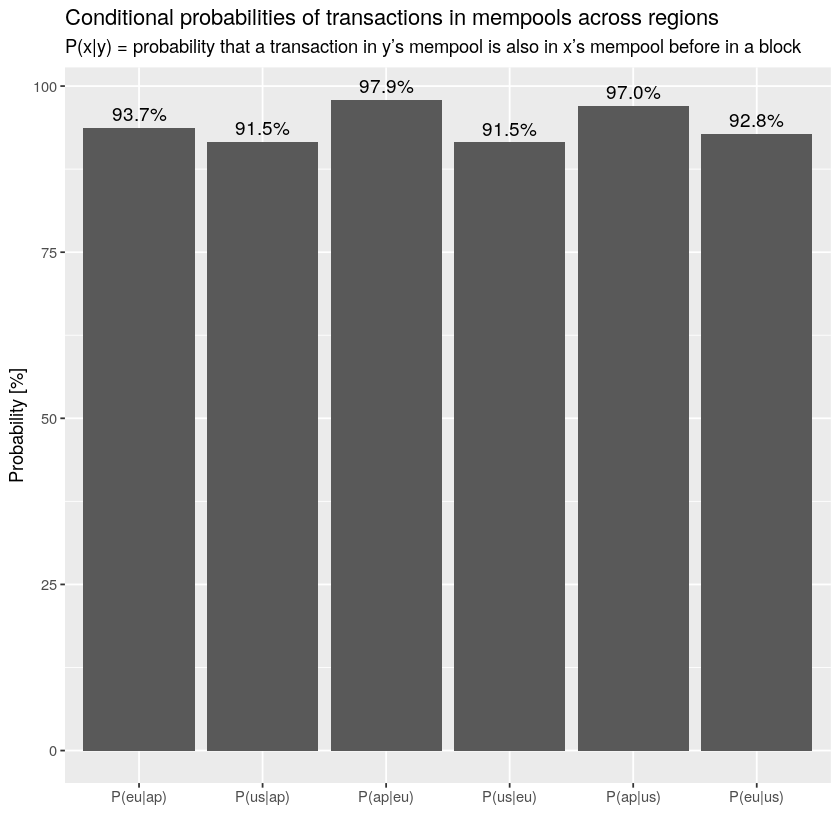

In [9]:
ggplot(
    melt(probabilities, id.vars="BAU?", variable.name="Condition", value.name="Probability")[`BAU?` == TRUE, .(`Condition`, `Probability [%]`=100*`Probability`)],
    aes(x=`Condition`, y=`Probability [%]`)
) +
    geom_bar(stat="identity") +
    geom_text(
        aes(label=sprintf("%.1f%%", `Probability [%]`)),
        vjust=-0.5,
        size=4
      ) +
    xlab("") +
    ggtitle(
        "Conditional probabilities of transactions in mempools across regions",
        "P(x|y) = probability that a transaction in y’s mempool is also in x’s mempool before in a block"
    )

In [10]:
ggsave("conditional-probability-regions.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("conditional-probability-regions.svg", units="in", dpi=150, width=8, height=6)